<a href="https://colab.research.google.com/github/rqchao/cs182-project/blob/main/gpt_neox_qlora.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q -U bitsandbytes
!pip install -q -U git+https://github.com/huggingface/transformers.git
!pip install -q -U git+https://github.com/huggingface/peft.git
!pip install -q -U git+https://github.com/huggingface/accelerate.git
!pip install -q datasets

First let's load the model we are going to use - GPT-neo-x-20B! Note that the model itself is around 40GB in half precision

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0,1"

In [2]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig

model_id = "tiiuae/falcon-7b-instruct"
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)

tokenizer = AutoTokenizer.from_pretrained(model_id)
model = AutoModelForCausalLM.from_pretrained(model_id, quantization_config=bnb_config, device_map="auto")

/home/xzrderek/.local/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Loading checkpoint shards: 100%|██████████| 2/2 [00:13<00:00,  6.92s/it]


Then we have to apply some preprocessing to the model to prepare it for training. For that use the `prepare_model_for_kbit_training` method from PEFT.

In [3]:
from peft import prepare_model_for_kbit_training

model.gradient_checkpointing_enable()
model = prepare_model_for_kbit_training(model)

In [4]:
def print_trainable_parameters(model):
    """
    Prints the number of trainable parameters in the model.
    """
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(
        f"trainable params: {trainable_params} || all params: {all_param} || trainable%: {100 * trainable_params / all_param}"
    )

In [5]:
from peft import LoraConfig, get_peft_model

r_list = [4, 8, 16]
lora_alpha_list = [16, 32, 64]
lora_dropout_list = [0.01, 0.05]

chosen_r, chosen_lora_alpha, chosen_lora_dropout = r_list[0], lora_alpha_list[2], lora_dropout_list[0]

config = LoraConfig(
    r=chosen_r,
    lora_alpha=chosen_lora_alpha,
    target_modules=["query_key_value", "dense", "dense_h_to_4h", "dense_4h_to_h"],
    lora_dropout=chosen_lora_dropout,
    bias="none",
    task_type="CAUSAL_LM"
)

model = get_peft_model(model, config)
print_trainable_parameters(model)

trainable params: 8159232 || all params: 3616904064 || trainable%: 0.22558607736409123


In [6]:
from datasets import load_dataset

dataset = load_dataset('csv', data_files='data/spongebob_lines2.csv')
dataset = dataset.map(lambda samples: tokenizer(samples["SpongeBob Lines"]), batched=True)
dataset = dataset['train'].train_test_split(test_size=0.2)

# dataset['train'] = dataset['train'].select(range(10))
# dataset['test'] = dataset['test'].select(range(10))

print(dataset)

DatasetDict({
    train: Dataset({
        features: ['SpongeBob Lines', 'input_ids', 'attention_mask'],
        num_rows: 9663
    })
    test: Dataset({
        features: ['SpongeBob Lines', 'input_ids', 'attention_mask'],
        num_rows: 2416
    })
})


Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.
You're using a PreTrainedTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/home/xzrderek/.local/lib/python3.11/site-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
The current implementation of Falcon calls `torch.scaled_dot_product_attention` directly, this will be deprecate

Step,Training Loss
1,4.304400
2,4.376200
3,4.126600
4,3.874300
5,4.063600
6,2.539100
7,3.732600
8,2.914700
9,4.376700
10,3.120900


r=4, lora_alpha=64, lora_dropout=0.01 
[4.3044, 4.3762, 4.1266, 3.8743, 4.0636, 2.5391, 3.7326, 2.9147, 4.3767, 3.1209, 3.34, 2.8166, 3.1813, 2.2847, 3.0742, 3.0726, 3.4271, 2.8881, 2.8862, 3.375, 2.5103, 2.6409, 2.5219, 2.7479, 2.8533, 2.4851, 3.5182, 3.7613, 2.9714, 2.7607, 2.2781, 2.537, 2.9455, 3.1947, 2.1794, 3.2304, 2.9622, 2.2599, 3.4116, 1.9507, 2.1636, 2.8354, 3.9085, 3.4363, 3.1013, 2.4161, 2.3518, 2.2288, 2.1146, 2.8544, 1.4032, 3.0909, 2.8081, 2.6588, 3.4199, 2.7011, 2.9911, 2.7396, 2.116, 3.0331, 2.5318, 2.2802, 2.3368, 3.2584, 2.4253, 1.9082, 2.1375, 2.3421, 2.3994, 2.5576, 2.1172, 2.8169, 2.8583, 3.4794, 2.7769, 3.0057, 2.3267, 2.3958, 2.5744, 2.654, 3.0597, 2.1699, 2.286, 2.6081, 2.5227, 2.4257, 2.3797, 2.4755, 3.0252, 2.4155, 2.5193, 2.3932, 2.7845, 3.4328, 2.4787, 3.0903, 3.3891, 2.4024, 2.8606, 2.6305]


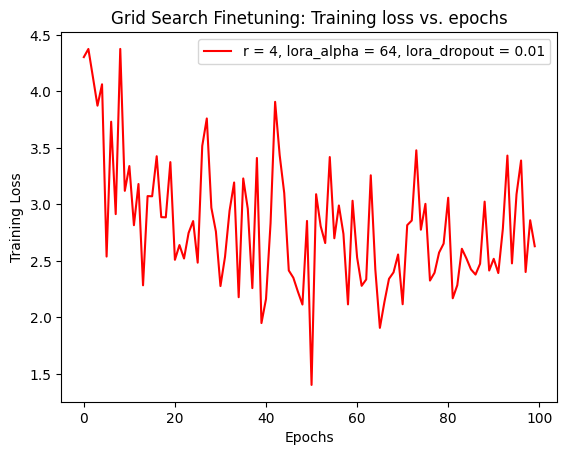

In [7]:
import transformers

import numpy as np
import matplotlib.pyplot as plt
from statistics import mean

device = torch.device("cuda")

# model = model.to(device)

# needed for gpt-neo-x tokenizer
tokenizer.pad_token = tokenizer.eos_token

trainer = transformers.Trainer(
    model=model,
    train_dataset=dataset["test"],
    args=transformers.TrainingArguments(
        per_device_train_batch_size=1,
        gradient_accumulation_steps=4,
        warmup_steps=2,
        max_steps=100,
        learning_rate=2e-4,
        fp16=True,
        logging_steps=1,
        output_dir="outputs",
        optim="paged_adamw_8bit"
    ),
    data_collator=transformers.DataCollatorForLanguageModeling(tokenizer, mlm=False),
)
model.config.use_cache = False  # silence the warnings. Please re-enable for inference!
trainer.train()

# print(trainer.state.log_history)

losses = []

for log in trainer.state.log_history:
    if 'loss' in log:
        losses.append(log['loss'])

# print(losses)

print(f"r={chosen_r}, lora_alpha={chosen_lora_alpha}, lora_dropout={chosen_lora_dropout} \n" + str(losses))

plt.title(f"Grid Search Finetuning: Training loss vs. epochs")
plt.xlabel("Epochs")
plt.ylabel("Training Loss")
plt.plot(range(len(losses)), losses, color ="red", label=f"r = {chosen_r}, lora_alpha = {chosen_lora_alpha}, lora_dropout = {chosen_lora_dropout}")
plt.legend()
plt.show()

In [10]:
import transformers

import numpy as np
import matplotlib.pyplot as plt
from statistics import mean

device = torch.device("cuda")

r_list = [4, 8, 16]
lora_alpha_list = [16, 32, 64]
lora_dropout_list = [0.01, 0.05]

best_loss = 1000
best_losses = []
iterations = 0

new_model = AutoModelForCausalLM.from_pretrained(model_id, quantization_config=bnb_config, device_map="auto", torch_dtype=torch.bfloat16)
new_model.gradient_checkpointing_enable()
new_model = prepare_model_for_kbit_training(new_model)

for r in r_list:
    for lora_alpha in lora_alpha_list:
        for lora_dropout in lora_dropout_list:

            config = LoraConfig(
                r=r,
                lora_alpha=lora_alpha,
                target_modules=["query_key_value"],
                lora_dropout=lora_dropout,
                bias="none",
                task_type="CAUSAL_LM"
            )

            model = get_peft_model(new_model, config)

            for i in model.named_parameters():
                print(f"{i[0]} -> {i[1].device}")

            # needed for gpt-neo-x tokenizer
            tokenizer.pad_token = tokenizer.eos_token

            trainer = transformers.Trainer(
                model=model,
                train_dataset=dataset["train"],
                args=transformers.TrainingArguments(
                    per_device_train_batch_size=1,
                    gradient_accumulation_steps=4,
                    warmup_steps=2,
                    max_steps=10,
                    learning_rate=2e-4,
                    fp16=True,
                    logging_steps=1,
                    output_dir="outputs",
                    optim="paged_adamw_8bit"
                ),
                data_collator=transformers.DataCollatorForLanguageModeling(tokenizer, mlm=False),
            )
            model.config.use_cache = False  # silence the warnings. Please re-enable for inference!
            trainer.train()

            # print(trainer.state.log_history)

            losses = []

            for log in trainer.state.log_history:
                if 'loss' in log:
                    losses.append(log['loss'])

            if losses[-1] < best_loss:
                best_r, best_lora_alpha, best_lora_dropout = r, lora_alpha, lora_dropout   
                best_losses = losses

print("Best r value: " + str(best_r))
print("Best lora_alpha value: " + str(best_lora_alpha))
print("Best lora_dropout value: " + str(best_lora_dropout))
print("Final Loss: " + str(best_loss))

plt.title("Grid Search Finetuning: Best training loss vs. epochs")
plt.xlabel("Epochs")
plt.ylabel("Training Loss")
plt.plot(range(len(best_losses)), best_losses, color ="red")
plt.legend()
plt.show()

Loading checkpoint shards: 100%|██████████| 2/2 [00:14<00:00,  7.13s/it]
Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


base_model.model.transformer.word_embeddings.weight -> cuda:0
base_model.model.transformer.h.0.self_attention.query_key_value.lora_A.default.weight -> cuda:0
base_model.model.transformer.h.0.self_attention.query_key_value.lora_B.default.weight -> cuda:0
base_model.model.transformer.h.0.self_attention.query_key_value.base_layer.weight -> cuda:0
base_model.model.transformer.h.0.self_attention.dense.weight -> cuda:0
base_model.model.transformer.h.0.mlp.dense_h_to_4h.weight -> cuda:0
base_model.model.transformer.h.0.mlp.dense_4h_to_h.weight -> cuda:0
base_model.model.transformer.h.0.input_layernorm.weight -> cuda:0
base_model.model.transformer.h.0.input_layernorm.bias -> cuda:0
base_model.model.transformer.h.1.self_attention.query_key_value.lora_A.default.weight -> cuda:0
base_model.model.transformer.h.1.self_attention.query_key_value.lora_B.default.weight -> cuda:0
base_model.model.transformer.h.1.self_attention.query_key_value.base_layer.weight -> cuda:0
base_model.model.transformer.h.1.

/home/xzrderek/.local/lib/python3.11/site-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


Step,Training Loss
1,3.633500
2,3.942800
3,3.554100
4,3.536400
5,4.634700
6,4.075200
7,3.234800
8,5.021900
9,3.680300
10,3.785300


Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


base_model.model.transformer.word_embeddings.weight -> cuda:0
base_model.model.transformer.h.0.self_attention.query_key_value.lora_A.default.weight -> cpu
base_model.model.transformer.h.0.self_attention.query_key_value.lora_B.default.weight -> cpu
base_model.model.transformer.h.0.self_attention.query_key_value.base_layer.weight -> cuda:0
base_model.model.transformer.h.0.self_attention.dense.weight -> cuda:0
base_model.model.transformer.h.0.mlp.dense_h_to_4h.weight -> cuda:0
base_model.model.transformer.h.0.mlp.dense_4h_to_h.weight -> cuda:0
base_model.model.transformer.h.0.input_layernorm.weight -> cuda:0
base_model.model.transformer.h.0.input_layernorm.bias -> cuda:0
base_model.model.transformer.h.1.self_attention.query_key_value.lora_A.default.weight -> cpu
base_model.model.transformer.h.1.self_attention.query_key_value.lora_B.default.weight -> cpu
base_model.model.transformer.h.1.self_attention.query_key_value.base_layer.weight -> cuda:0
base_model.model.transformer.h.1.self_attenti

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu! (when checking argument for argument mat2 in method wrapper_CUDA_mm)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


[{'loss': 4.0284, 'learning_rate': 0.0001, 'epoch': 0.0, 'step': 1}, {'loss': 4.6069, 'learning_rate': 0.0002, 'epoch': 0.0, 'step': 2}, {'loss': 4.2995, 'learning_rate': 0.00019795918367346938, 'epoch': 0.0, 'step': 3}, {'loss': 3.1777, 'learning_rate': 0.0001959183673469388, 'epoch': 0.0, 'step': 4}, {'loss': 3.777, 'learning_rate': 0.00019387755102040816, 'epoch': 0.0, 'step': 5}, {'loss': 3.4194, 'learning_rate': 0.00019183673469387756, 'epoch': 0.0, 'step': 6}, {'loss': 3.0763, 'learning_rate': 0.00018979591836734697, 'epoch': 0.0, 'step': 7}, {'loss': 3.6489, 'learning_rate': 0.00018775510204081634, 'epoch': 0.0, 'step': 8}, {'loss': 3.3619, 'learning_rate': 0.00018571428571428572, 'epoch': 0.0, 'step': 9}, {'loss': 2.6703, 'learning_rate': 0.00018367346938775512, 'epoch': 0.0, 'step': 10}, {'loss': 3.1165, 'learning_rate': 0.0001816326530612245, 'epoch': 0.0, 'step': 11}, {'loss': 3.0387, 'learning_rate': 0.0001795918367346939, 'epoch': 0.0, 'step': 12}, {'loss': 3.1093, 'learni

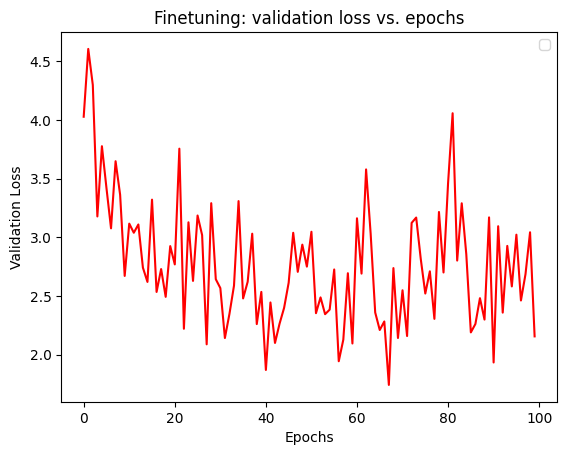

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from statistics import mean

print(trainer.state.log_history)

losses = []

for log in trainer.state.log_history:
    if 'loss' in log:
        losses.append(log['loss'])

# print(losses)

plt.title("Finetuning: training loss vs. epochs")
plt.xlabel("Epochs")
plt.ylabel("Training Loss")
plt.plot(range(len(losses)), losses, color ="red")
plt.legend()
plt.show()

In [ ]:
# Iterating over all parameters of the model. In deep learning models, parameters are the parts of the model that are learned from the training data, such as weights.
for parameter in model.parameters():
    # Freezing the parameter. This means that this parameter will not be updated during training.
    # This is done to keep the pre-trained knowledge intact while we fine-tune only certain parts of the model.
    parameter.requires_grad = False

# Transformer models are typically composed of several layers (or blocks) stacked on top of each other.
for i, m in enumerate(model.transformer.h):
    # Checking if the current block is one of the last 'n' blocks.
    # 'config['UNFREEZE_LAST_N']' specifies how many of the last blocks should be unfrozen.

    if i + 1 > 12 - config['UNFREEZE_LAST_N']:
        for parameter in m.parameters():
            # Unfreezing is done so that these parameters can be updated during training.
            parameter.requires_grad = True 

# Unfreezing the parameters of the layer normalization at the end of the transformer.
for parameter in model.transformer.ln_f.parameters():
    parameter.requires_grad = True

# Unfreezing the parameters of the language model head. The 'lm_head' is typically the output layer of the model.
for parameter in model.lm_head.parameters():
    parameter.requires_grad = True


# Utilize best hyperparameters from grid search from above.
config = LoraConfig(
    r=best_r,
    lora_alpha=best_lora_alpha,
    target_modules=["query_key_value"],
    lora_dropout=best_lora_dropout,
    bias="none",
    task_type="CAUSAL_LM"
)


trainer = transformers.Trainer(
    model=model,
    train_dataset=dataset["train"],
    args=transformers.TrainingArguments(
        per_device_train_batch_size=1,
        gradient_accumulation_steps=4,
        warmup_steps=2,
        max_steps=10,
        learning_rate=2e-4,
        fp16=True,
        logging_steps=1,
        output_dir="outputs",
        optim="paged_adamw_8bit"
    ),
    data_collator=transformers.DataCollatorForLanguageModeling(tokenizer, mlm=False),
)
model.config.use_cache = False  # silence the warnings. Please re-enable for inference!
trainer.train()

In [8]:
shuffled_dataset = dataset['test'].shuffle()
shuffled_dataset = shuffled_dataset[:1000]

print(shuffled_dataset)

{'SpongeBob Lines': ['Rube: I understand how you feel, Birthday Bob, but what can we do about it?', 'ChefBob: Huh?', 'Sandy: Hang in there, little buddy!', 'Squidward: This is your fault!', "Pearl: That's grease!", 'Flying Dutchman:  Liar!', "♪You got to believe. It was out of sight. You got to believe. I'm back in Encino. You got to believe. Everything's all right. The sky above, and the ground below. Bring me back into Encino. It was lost, some time ago, I'm just glad to be back home. You got to believe. I'm back in Encino. You got to believe. Everything's all right. You got to believe. I'm back in Eencino. You got to believe. Everything's all right.♪", "Sandy:  Zero as being everyone's collective IQ.", 'Mr. Krabs: Uhh, well, actually, I was going to show you this flip book and...', 'Plankton: Now what are they saying, Karen? Karen?!', "Patrick: Let's get some!", "Mermaid Man: Let's see... I want a... no.  I want a...  uh, no, uh, hmmm...", "Patrick:  Leaping lampreys, Mermaid Man! I

In [9]:
import torch
from tqdm import tqdm

# print(dataset['test']['SpongeBob Lines'])

encodings = tokenizer("\n\n".join(shuffled_dataset['SpongeBob Lines']), return_tensors="pt")

# print(encodings.input_ids)

# print(model.config)

max_length = model.config.max_position_embeddings
stride = 512
seq_len = encodings.input_ids.size(1)

nlls = []
prev_end_loc = 0
for begin_loc in tqdm(range(0, seq_len, stride)):
    end_loc = min(begin_loc + max_length, seq_len)
    trg_len = end_loc - prev_end_loc  # may be different from stride on last loop
    input_ids = encodings.input_ids[:, begin_loc:end_loc].to(device)
    target_ids = input_ids.clone()
    target_ids[:, :-trg_len] = -100

    with torch.no_grad():
        outputs = model(input_ids, labels=target_ids)

        # loss is calculated using CrossEntropyLoss which averages over valid labels
        # N.B. the model only calculates loss over trg_len - 1 labels, because it internally shifts the labels
        # to the left by 1.
        neg_log_likelihood = outputs.loss

    nlls.append(neg_log_likelihood)

    prev_end_loc = end_loc
    if end_loc == seq_len:
        break

ppl = torch.exp(torch.stack(nlls).mean())

print(ppl)

Token indices sequence length is longer than the specified maximum sequence length for this model (21881 > 2048). Running this sequence through the model will result in indexing errors
  0%|          | 0/43 [00:00<?, ?it/s]

/home/xzrderek/.local/lib/python3.11/site-packages/torch/utils/checkpoint.py:61: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
 91%|█████████ | 39/43 [00:55<00:05,  1.43s/it]

tensor(12.4213, device='cuda:1')


In [10]:
print(ppl)

tensor(12.4213, device='cuda:1')


In [11]:
base_model_id = "tiiuae/falcon-7b-instruct"
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)

base_config = LoraConfig(
    r=8,
    lora_alpha=32,
    target_modules=["query_key_value", "dense", "dense_h_to_4h", "dense_4h_to_h"],
    lora_dropout=0.05,
    bias="none",
    task_type="CAUSAL_LM"
)

base_tokenizer = AutoTokenizer.from_pretrained(base_model_id)
base_model = AutoModelForCausalLM.from_pretrained(base_model_id, quantization_config=bnb_config, device_map="auto")

base_model.gradient_checkpointing_enable()
base_model = prepare_model_for_kbit_training(base_model)

base_model = get_peft_model(base_model, base_config)

base_encodings = tokenizer("\n\n".join(shuffled_dataset['SpongeBob Lines']), return_tensors="pt")

max_length = base_model.config.max_position_embeddings
stride = 512
seq_len = base_encodings.input_ids.size(1)

nlls = []
prev_end_loc = 0
for begin_loc in tqdm(range(0, seq_len, stride)):
    end_loc = min(begin_loc + max_length, seq_len)
    trg_len = end_loc - prev_end_loc  # may be different from stride on last loop
    input_ids = base_encodings.input_ids[:, begin_loc:end_loc].to(device)
    target_ids = input_ids.clone()
    target_ids[:, :-trg_len] = -100

    with torch.no_grad():
        outputs = base_model(input_ids, labels=target_ids)

        # loss is calculated using CrossEntropyLoss which averages over valid labels
        # N.B. the model only calculates loss over trg_len - 1 labels, because it internally shifts the labels
        # to the left by 1.
        neg_log_likelihood = outputs.loss

    nlls.append(neg_log_likelihood)

    prev_end_loc = end_loc
    if end_loc == seq_len:
        break

base_ppl = torch.exp(torch.stack(nlls).mean())

print(base_ppl)

 91%|█████████ | 39/43 [02:15<00:13,  3.47s/it]

tensor(12.1512, device='cuda:1')


In [12]:
input_text = "SpongeBob, write me a short poem please!"
input_ids = tokenizer.encode(input_text, return_tensors='pt')

# Generate a response
output = model.generate(input_ids=input_ids, max_length=100, num_return_sequences=1)
generated_text = tokenizer.decode(output[0], skip_special_tokens=True)

print("Generated text: " + str(generated_text))

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Generated text: SpongeBob, write me a short poem please!
I'm so happy, I'm so happy,
My heart is filled with joy.
I'm so happy, I'm so happy,
My soul is singing joyfully.

I'm so happy, I'm so happy,
My spirit is soaring high.
I'm so happy, I'm so happy,
My mind is filled with delight.

I'm


# BLEU Score

In [13]:
!pip install nltk

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [20]:
import csv

def csv_to_list_of_strings(file_path):
    """
    Reads a CSV file and converts each row into a string.
    Assumes that the CSV file contains text data.

    :param file_path: Path to the CSV file.
    :return: A list of strings, where each string is a row from the CSV file.
    """
    list_of_strings = []
    with open(file_path, newline='', encoding='utf-8') as csvfile:
        reader = csv.reader(csvfile)
        for row in reader:
            # Convert each row to a string and append to the list
            row_string = ', '.join(row)
            list_of_strings.append(row_string)
    return list_of_strings

# Example usage
file_path = 'data/spongebob_lines.csv'
strings_from_csv = csv_to_list_of_strings(file_path)
print(strings_from_csv)

['Lines', "Hold on, I'll check the textbook.  Ah, Your Mirror and You. Hmm, proper seat belt hygiene? No.", 'Hooray!', "Mrs. Puff! Oh, there you are.  I'll make it up to you, Mrs. Puff. I'll shine your shoes!  Dry your hair!  Oil your boat?", 'I love cleaning!', 'That takes care of that.  Yuck. This place needs a good scrub.', "Ah, almost done. I just need to shine out that old lighthouse's lantern.  The lighthouse is haunted! Just like my toaster.", 'That box is haunted!  These stairs are haunted!  This trash is haunted.', 'Ahh! Ghost snail!', "Oh, you're no ghost. Just a cute little stray snail. How about I call you Louie? Lighthouse Louie!", "Now, Louie, you'll be good while uncle SpongeBob cleans.", "Louie, I'm afraid you'll have to play out here, little fella. For your own safety.  What! Louie?  Well, that oughta keep you out of my HAIR!", 'Sorry, Louie, you have to stay outside.  No silly little snail is a match for my superior sponge brain!   And the bait: one can-o-patty.', "Go

In [25]:
import nltk
from nltk.translate.bleu_score import sentence_bleu
nltk.download('punkt')

def calculate_bleu_score(model_output, reference_texts):
    """
    Calculate the BLEU score for a model output against a set of reference texts.

    :param model_output: A string representing the output from the language model.
    :param reference_texts: A list of strings, where each string is a reference text.
    :return: The BLEU score for the model output.
    """

    # Tokenizing the model output and the reference texts
    model_output_tokens = nltk.word_tokenize(model_output)
    reference_tokens = [nltk.word_tokenize(ref) for ref in reference_texts]

    # Calculating BLEU score
    score = sentence_bleu(reference_tokens, model_output_tokens)
    return score

# Example usage
model_output_1 = "I'm not sure."
model_output_2 = "I'm so happy, I'm so happy,\
My heart is filled with joy.\
I'm so happy, I'm so happy,\
My soul is singing joyfully.\
I'm so happy, I'm so happy,\
My spirit is soaring high.\
I'm so happy, I'm so happy,\
My mind is filled with delight."
model_output_3 = "I mean, besides the paycheck."
reference_texts = strings_from_csv

bleu_score_mean = mean([calculate_bleu_score(model_output_1, reference_texts), 
                       calculate_bleu_score(model_output_2, reference_texts),
                       calculate_bleu_score(model_output_3, reference_texts)])
print("Average BLEU Score:", bleu_score_mean)


[nltk_data] Downloading package punkt to /home/xzrderek/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Average BLEU Score: 0.39472306614714386


/home/xzrderek/.local/lib/python3.11/site-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
